In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import itertools
from scipy.stats import spearmanr

from pathlib import Path

import os
import sys  

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_colocalization_scores

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Pixelator_data"

In [2]:
# all possible markers from the MPX method
marker_names = ['CD9', 'CD62P', 'CD27', 'CD36', 'mIgG2b', 'CD337', 'CD3E', 'CD274', 'CD55', 'CD161', 'CD14', 'CD48', 'CD82', 'CD64', 
                'CD11c', 'CD54', 'CD11b', 'CD44', 'CD154', 'B2M', 'CD268', 'CD18', 'CD37', 'CD4', 'CD29', 'CD11a', 'CD47', 'CD7', 
                'CD2', 'CD35', 'CD45', 'CD8', 'CD314', 'CD22', 'CD19', 'CD127', 'CD53', 'CD52', 'CD229', 'CD72', 'CD59', 'CD163', 'CD38', 
                'CD25', 'CD41', 'CD150', 'CD278', 'CD152', 'mIgG1',  'CD5', 'CD26', 'CD197', 'CD50', 'CD328', 'CD279', 'CD200', "ACTB",
                'CD71', 'CD102', 'CD244', 'CD45RB', 'CD40', 'CD45RA', 'CD84', 'CD49D', 'CD162', 'CD1d', 'CD137', 'CD32', 'CD69', 'CD20', 'CD33', 
                'CD158', 'HLA-ABC', 'mIgG2a', 'CD86', 'CD43', 'CD16', 'TCRb', 'HLA-DR']

combinations = list(itertools.product(["CD50"], marker_names))

In [3]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S0"

# calculate pairwise colocalization scores
similarity_measure_df_S0 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S0 = similarity_measure_df_S0.apply(lambda x: np.nan_to_num(x))

In [4]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S1"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S1 = similarity_measure_df_S1.apply(lambda x: np.nan_to_num(x))

In [5]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S3 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S3 = similarity_measure_df_S3.apply(lambda x: np.nan_to_num(x))

In [6]:
# combine the two colocalization dataframes
df_original = pd.concat([similarity_measure_df_S3.T, similarity_measure_df_S1.T, similarity_measure_df_S0.T], 
                        keys=['Stimulated', 'Fixed control', 'Control']).reset_index().drop(labels=["level_1"], axis=1).set_index("level_0")

df_original = df_original.drop("CD50_CD50",axis=1)

#df_original = df_original.drop(labels=["CD50_CD50"], axis=1)
df = df_original.melt(ignore_index=False)

In [7]:
top_pol_mean = df_original.groupby("level_0").get_group("Stimulated").apply(lambda x: np.mean(x))
top_pol_mean = top_pol_mean.sort_index()

gen_pop_mean = df_original.groupby("level_0").get_group("Fixed control").apply(lambda x: np.mean(x))
gen_pop_mean = gen_pop_mean.sort_index()

least_pol_mean = df_original.groupby("level_0").get_group("Control").apply(lambda x: np.mean(x))
least_pol_mean = least_pol_mean.sort_index()

differential_1 = top_pol_mean - gen_pop_mean
differential_1 = differential_1.apply(lambda x: np.round(x, 5))

differential_2 = top_pol_mean - least_pol_mean
differential_2 = differential_2.apply(lambda x: np.round(x, 5))

In [8]:
import scipy
from scipy.stats import wilcoxon

def statical_test(df_statistics, frist_sample, second_sample):

    statistical_significance = []
    for x_pos, marker_combination in enumerate(df_statistics.columns):
        scores_marker_1 = df_statistics.groupby("level_0").get_group(frist_sample)[marker_combination].values[:650]
        scores_marker_2 = df_statistics.groupby("level_0").get_group(second_sample)[marker_combination].values[:650]

        if max(scores_marker_1) == 0 and min(scores_marker_1) == 0 and max(scores_marker_2) == 0 and min(scores_marker_2) == 0:
            statistical_significance.append(np.nan)
        else:
            test = wilcoxon(x=scores_marker_1, y=scores_marker_2)
            
            p_value = test[1]
            if 0.01 < p_value:
                statistical_significance.append(np.nan)

            elif 0.001 < p_value and p_value < 0.01:
                statistical_significance.append(x_pos)

            elif 0.0001 < p_value and p_value < 0.001:
                statistical_significance.append(x_pos - 0.175)
                statistical_significance.append(x_pos + 0.175)

            else:
                statistical_significance.append(x_pos - 0.275)
                statistical_significance.append(x_pos)
                statistical_significance.append(x_pos + 0.275)

    return statistical_significance

# run statistics
statists_S_FC = statical_test(df_original.sort_values(["Marker_combinations"], axis=1), "Stimulated", "Fixed control")
statists_S_C = statical_test(df_original.sort_values(["Marker_combinations"], axis=1), "Stimulated", "Control")

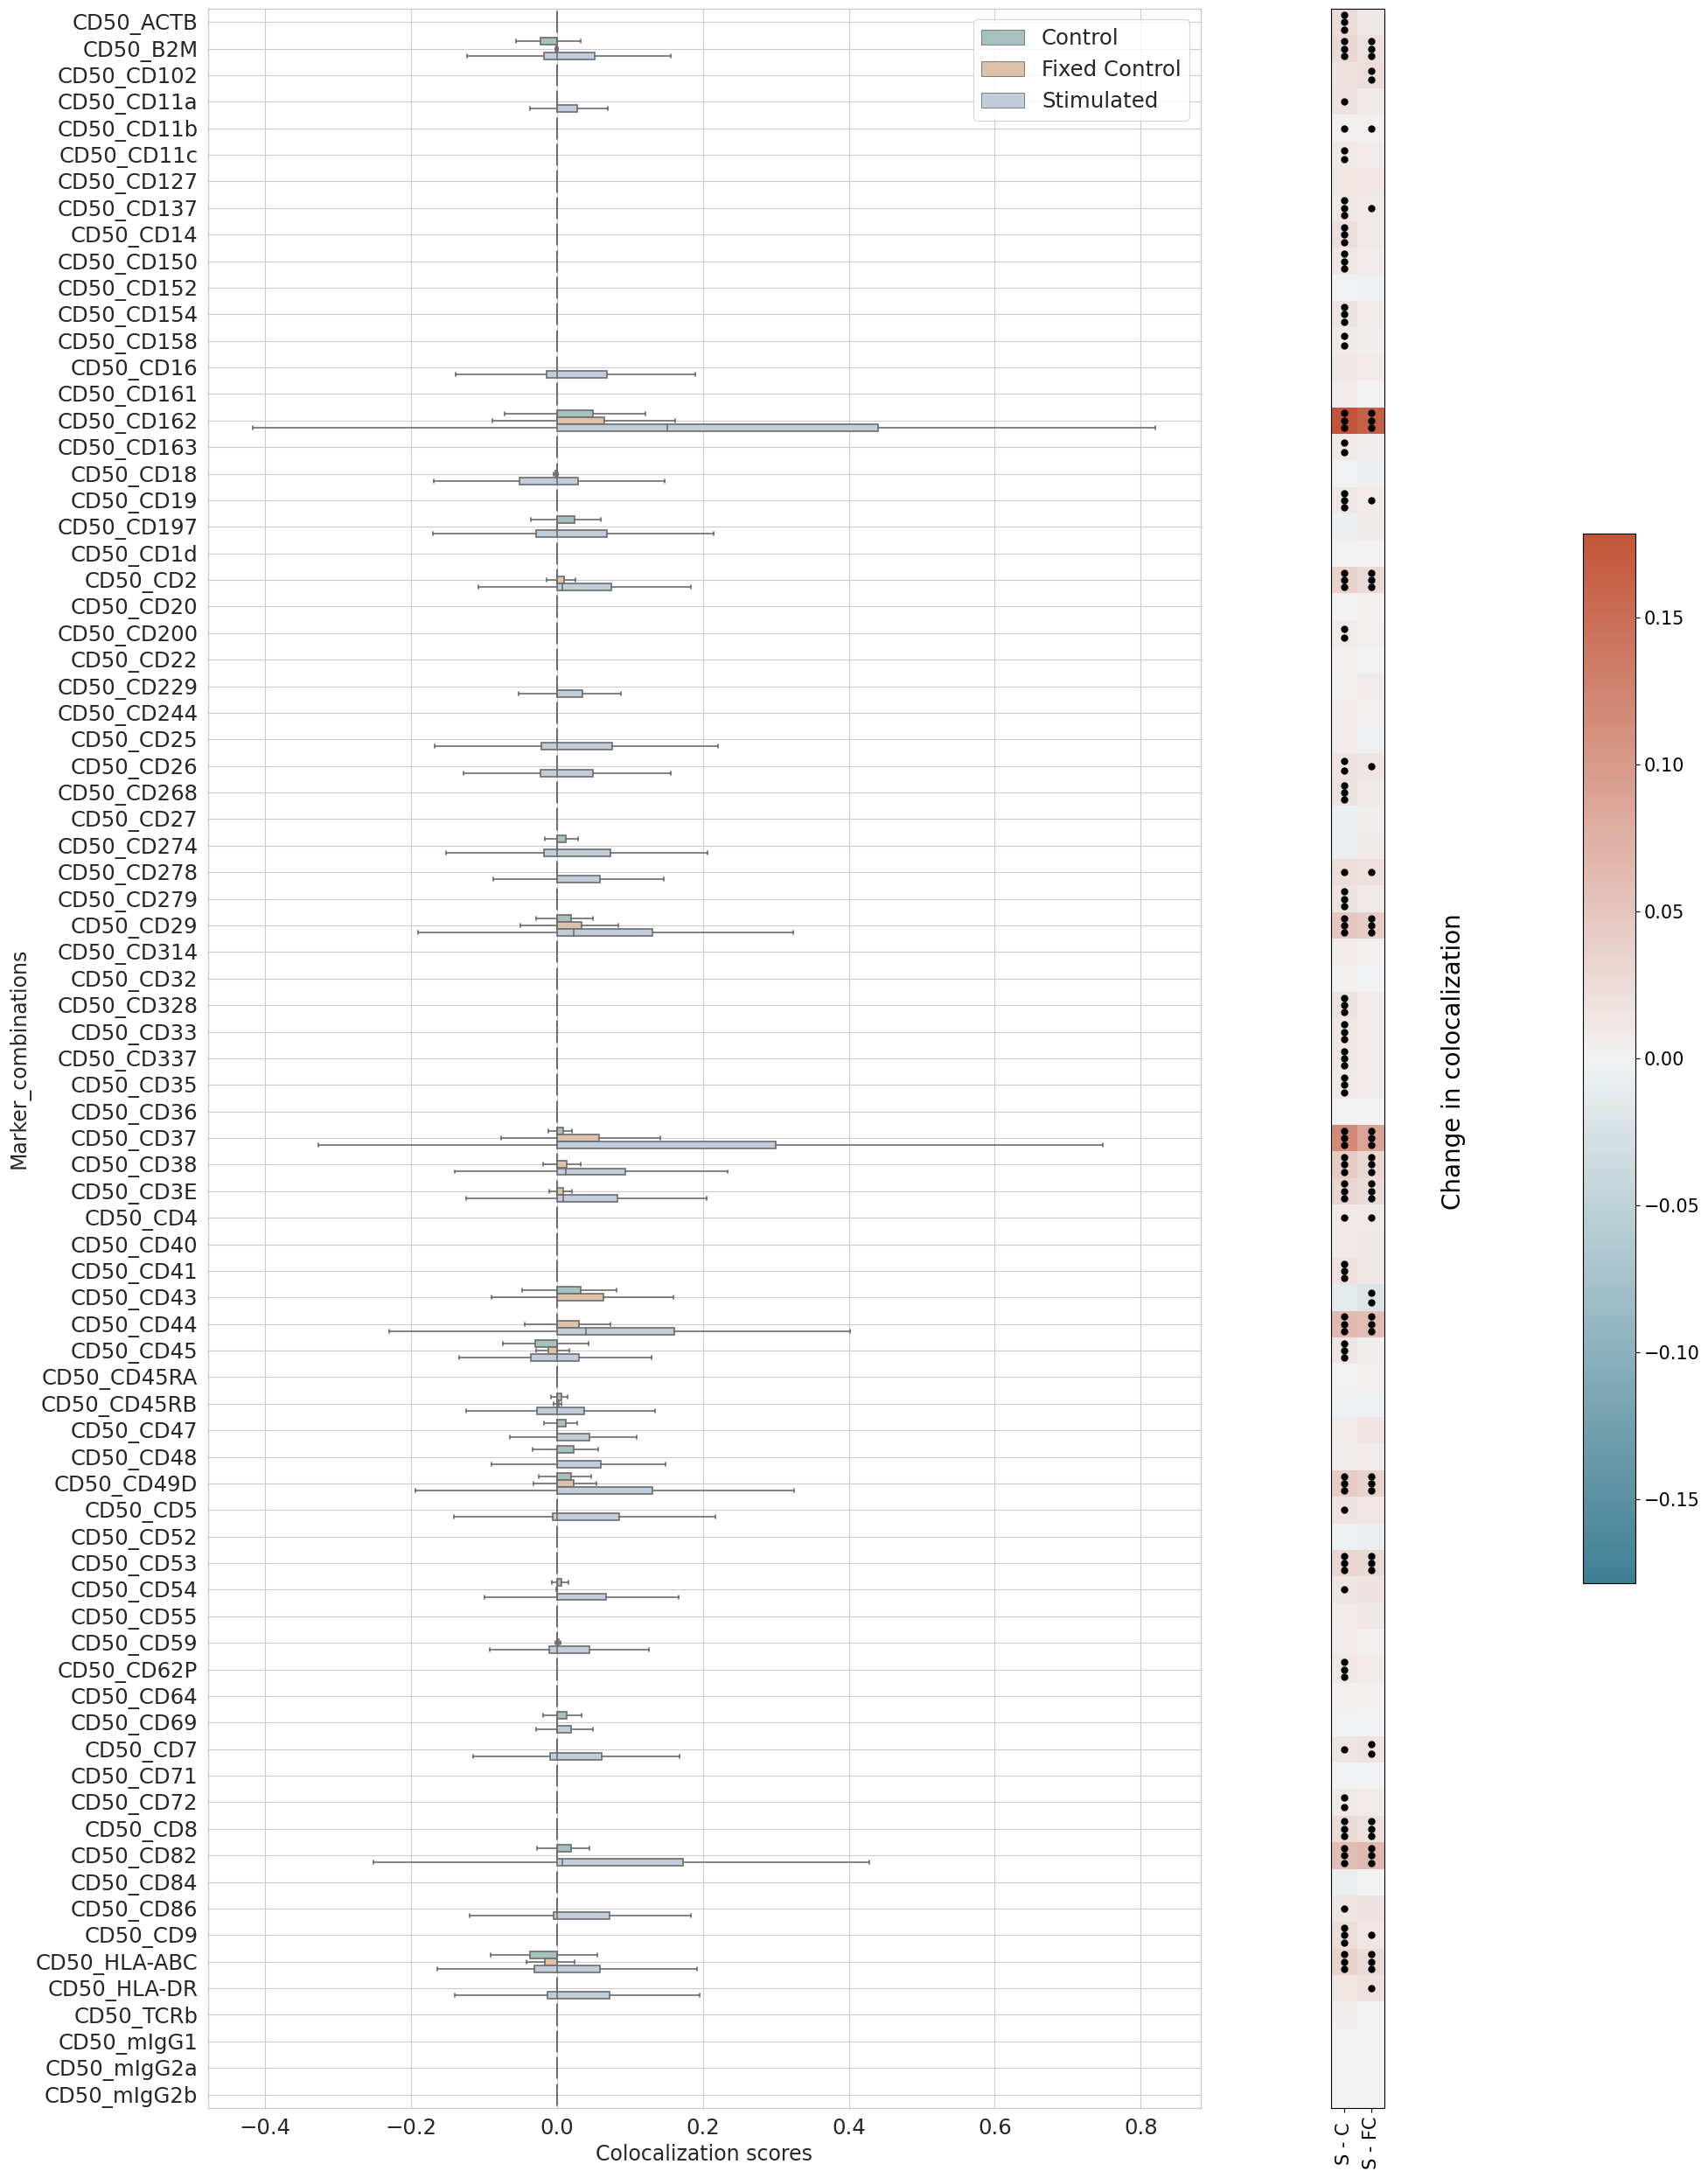

In [9]:
import scipy
sns.set(rc={'figure.figsize':(15, 45)})
sns.set_theme(context="paper", style="whitegrid", font_scale=2)

fig = plt.figure(figsize=(20, 25))
#fig.suptitle('Differential colocalization', fontsize=22)

ax = fig.add_subplot(1, 2, 1)
plt.subplots_adjust(left=2, right=3)
ax = sns.boxplot(data=df.sort_values(['Marker_combinations', 'level_0']), x="value", y="Marker_combinations",  hue=df.index.values, 
                 showfliers=False, width=0.8, palette=["#A2C6C2", "#E3C29F", "#BDCCDF" ])

handles, _ = ax.get_legend_handles_labels()          # Get the artists.
ax.legend(handles, ["Control", "Fixed Control", "Stimulated"], loc="best")

# adjust axis
ax.yaxis.grid(True)
plt.xlabel("Colocalization scores", fontsize=17)
plt.ylabel("Marker_combinations", fontsize=17)

sns.reset_orig()
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Change in colocalization", fontsize=20, x=2.3, y=0.427, rotation=90)

# get max values of the difference to create color bar values
max_values = max([max(np.abs(differential_1.values)), max(np.abs(differential_2.values))])

# test sigificane of mean shift for stimualted and fixed control sample, more dots = more sigificant
sns.scatterplot(x=[0] * len(statists_S_C), y=statists_S_C, color="black", sizes=5, linewidth=0)
sns.scatterplot(x=[1] * len(statists_S_FC), y=statists_S_FC, color="black", sizes=5, linewidth=0)

# plot colorbar indicading the shift of colocalization
rotated_img = scipy.ndimage.rotate([differential_1.values, differential_2.values], 270)
im = plt.imshow(rotated_img, interpolation='none', aspect='equal', 
                cmap=sns.diverging_palette(220, 20, as_cmap=True), vmin=-max_values, vmax=max_values)

# add colorbar
cb = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.2, shrink=0.5)
cb.ax.tick_params(labelsize=15)

# remove labels from the axis
ax.set_xticklabels(["S - C ", "S - FC"], fontsize=15, rotation=90)
ax.set_yticklabels([])
ax.set_xticks([0, 1])
ax.set_yticks([])

plt.tight_layout()
plt.show()
#plt.savefig("Pairwise_diff_plot_uropods.jpg")